In [1]:
pip install legume-gme

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
oldest-supported-numpy 2023.12.21 requires numpy==1.23.2; python_version == "3.11", but you have numpy 1.26.4 which is incompatible.


In [2]:

import legume

import numpy as np
import matplotlib.pyplot as  plt

import autograd.numpy as npa
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [3]:
slab_height = 0.15
ring_width = 0.07
ring_number = 7
ring_period = 0.155

GaAs_permittivity = 12.25
Lx, Ly = 12, 12

In [30]:
lattice = legume.Lattice([Lx, 0], [0, Ly])
phc = legume.PhotCryst(lattice)

phc.add_layer(d=slab_height, eps_b=GaAs_permittivity)

# Hole parameters (radius in µm, diameter in nm, number of holes originally in one quadrant)
hole_layers = [
    (0.402, 77, 5),
    (0.557, 72, 6),
    (0.795, 126, 8),
    (0.998, 135, 8),
    (1.214, 144, 10),
    (1.452, 126, 12),
    (1.654, 90, 17),
    (1.823, 72, 18),
    (1.992, 72, 19),
    (2.332, 63, 20),
    (2.654, 117, 22),
    (2.965, 126, 23),
    (3.297, 144, 24),
    (3.643, 144, 25),
    (3.963, 144, 26),
    (4.331, 144, 28),
    (4.704, 126, 29),
]

holes = []
for radius, diameter_nm, count_quadrant in hole_layers:
    diameter_um = diameter_nm / 1000.0
    total_holes = count_quadrant * 4
    angles = npa.linspace(0, 2 * npa.pi, total_holes, endpoint=False)
    for angle in angles:
        x = radius * npa.cos(angle)
        y = radius * npa.sin(angle)
        hole = legume.Circle(eps=1, x_cent=x, y_cent=y, r=diameter_um / 2)
        holes.append(hole)

phc.add_shape(holes)


In [31]:
def get_kpoints(Lx, Ly, nkx, nky):

  # sample nkx and nky points in {kx, ky} space in a uniform grid
  # spacing between two reciprocal vectors is 2*pi/N

  kx = npa.linspace(0, (nkx-1)/nkx*2*np.pi/Lx, nkx)
  ky = npa.linspace(0, (nky-1)/nky*2*np.pi/Ly, nky)
  kxg, kyg = npa.meshgrid(kx, ky)
  kxg = kxg.ravel()
  kyg = kyg.ravel()

  kpoints = npa.vstack((kxg, kyg))

  return kpoints

In [32]:
kpoints_number = 2
kpoints = get_kpoints(Lx, Ly, kpoints_number, kpoints_number)

In [33]:
def gme_cavity(dx, dy, dz, gmax, truncate_g, options):

  options['compute_im'] = False

  gme = legume.GuidedModeExp(phc, gmax = gmax, truncate_g = truncate_g)
 

  gme.run(kpoints = kpoints, **options)


  return gme

In [34]:
def Q_factor_calculation(gme, kpoints, mode_index):

  freq_im_array = []

  for i in range(kpoints[0, :].size):

    (freq_im, _, _) = gme.compute_rad(0, [mode_index])
    freq_im_array.append(freq_im)

  Q = gme.freqs[0, mode_index]/2/np.mean(freq_im_array)

  return Q

In [35]:
def out_eigenvec(gme, mode_index):

    return gme.eigvecs[0][:, mode_index]

<Figure size 800x800 with 0 Axes>

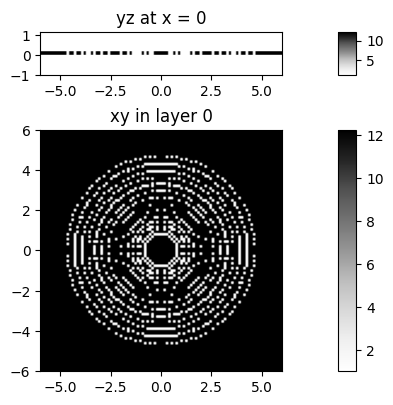

In [36]:

plt.figure(figsize=(8, 8))
legume.viz.structure(phc, yz=True, figsize=4., cbar=True)
#plt.title(f"Structure at Epoch {epoch}")
plt.show()

In [79]:
options = {
    'gmode_inds': [0],
    'verbose': True,
    'numeig': 1500,
    'eig_sigma': 1.06,
    'gradients': 'approx'
}

gmax = 4

truncate_g = 'abs'
dx = 0.0
dy = 0.0
dz = 0.0

gme = gme_cavity(dx, dy, dz, gmax, truncate_g, options)

Plane waves used in the expansion = 7213.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 7213 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'         │ 1.690    │ │--------------------│    0% │
│ Inverse matrix of Fourier-space permittivity                │ 24.167   │ │--------------------│    1% │
│ Matrix diagionalization using the 'eigh' solver             │ 1709.247 │ │█████████████████---│   86% │
│ Creating GME matrix                                         │ 261.289  │ │██------------------│   13% │
├─────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 4 k-points      │ 1996.478 │ │████████████████████│  100% │
└─────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

Index number 630
Index number 631
Index number 632
Index number 633
Index number 634
Index number 635
Index number 636
Index number 637
Index number 638
Index number 639


<Figure size 640x480 with 0 Axes>

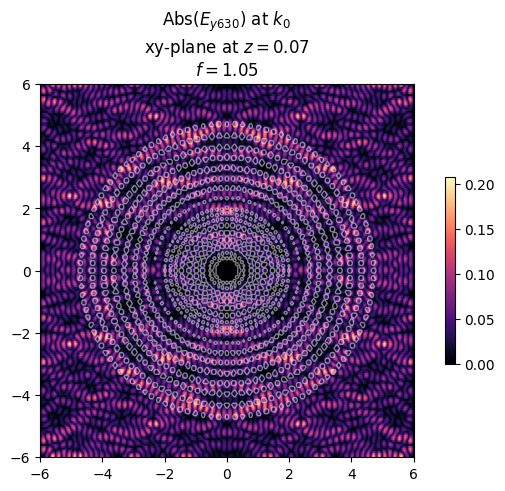

<Figure size 640x480 with 0 Axes>

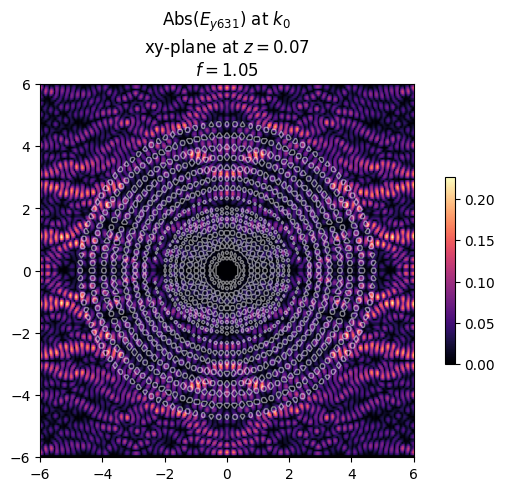

<Figure size 640x480 with 0 Axes>

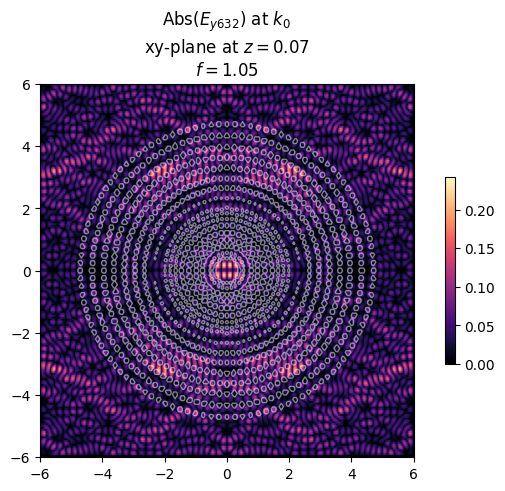

<Figure size 640x480 with 0 Axes>

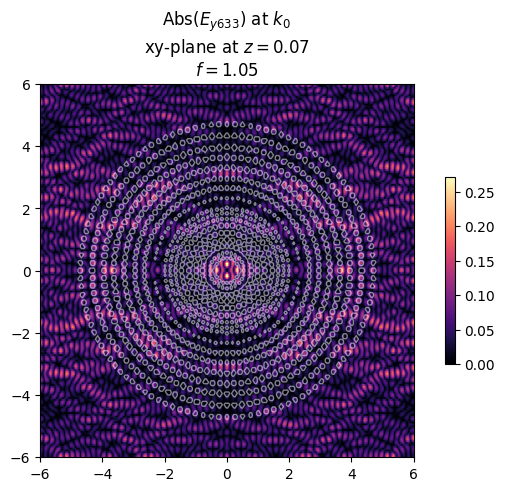

<Figure size 640x480 with 0 Axes>

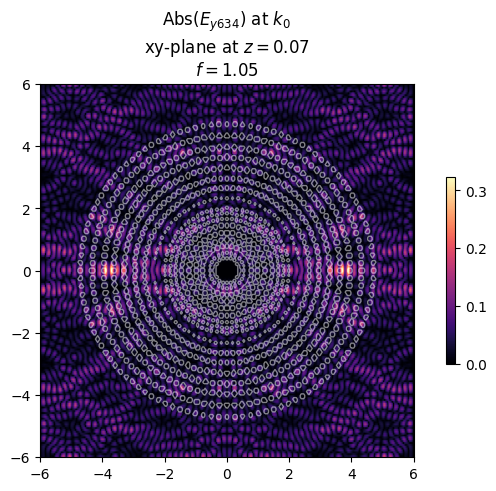

<Figure size 640x480 with 0 Axes>

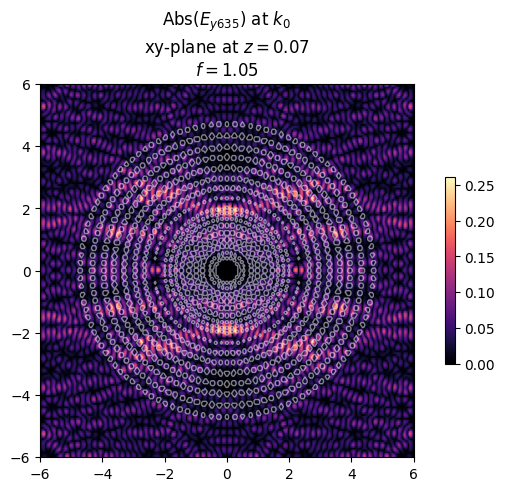

<Figure size 640x480 with 0 Axes>

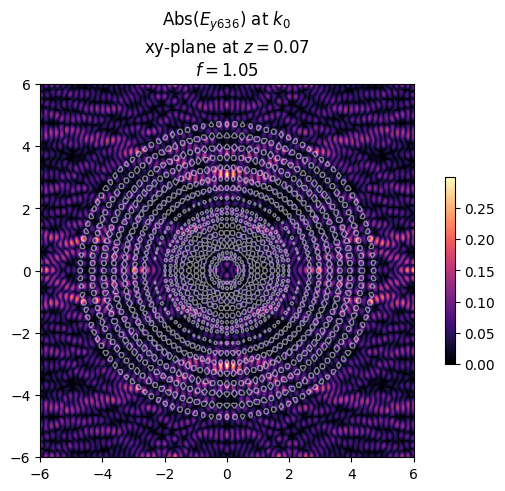

<Figure size 640x480 with 0 Axes>

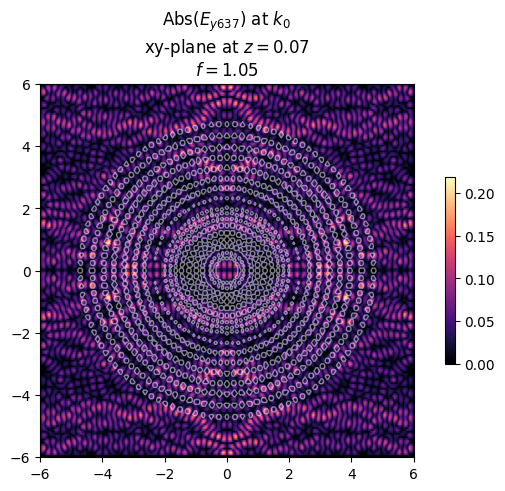

<Figure size 640x480 with 0 Axes>

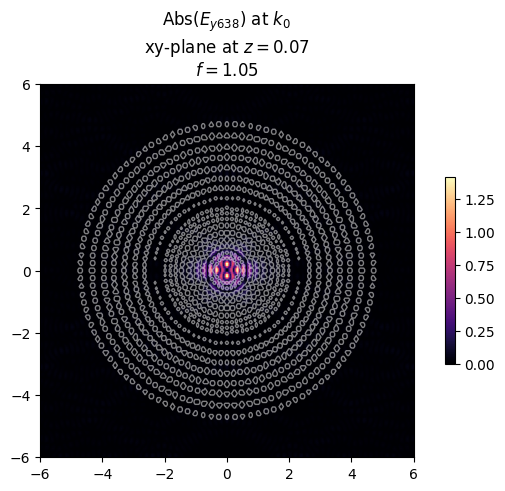

<Figure size 640x480 with 0 Axes>

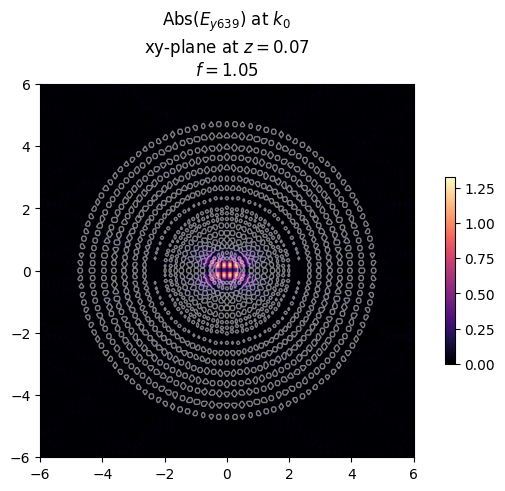

In [83]:
for index in range(630, 640):
    print(f"Index number {index}")
    
    # Optional: compute Q factor (uncomment if function is defined)
    # Q_factor = Q_factor_calculation(gme, index)
    # print("Cavity quality factor: %1.2f" % Q_factor)

    # Plot mode profile
    plt.figure()
    ax = legume.viz.field(gme, 'e', 0, index, z = slab_height/2, component = 'y', val = 'abs', N1 = 300, N2 = 200)


In [84]:
Q_factor = Q_factor_calculation(gme, kpoints, 638)
print("Cavity quality factor: %1.2f" %Q_factor)

Cavity quality factor: 3261.23


In [85]:
print(gme.freqs[0, 638])

1.049513913517023


In [87]:
initial_target_eigenvec = out_eigenvec(gme, 638)
np.save("initial_tgt_eigvec_gmax=4numeig=1500mode=638.npy", initial_target_eigenvec)